# Data Exploration in Splice Machine
<blockquote><p class='quotation'><span style='font-size:15px'> Data exploration couldn't be easier on Splice. Our build in, scalable Spark Sessions allow you do run massive analytics, and our robust library support removes the learning curve. In this notebook, we'll ingest our SQL table into a Spark Dataframe using the Native Spark Datasource, and then use <code>Koalas</code> to give us Pandas API syntax on distributed Spark Dataframes! <a href=https://koalas.readthedocs.io/en/latest/getting_started/index.html>Koalas</a> is a powerful library and removes the need to learn PySpark syntax to run large scale analytics on your data.<br>

In order to use Koalas (or any other custom library you'd like), simply <code>pip install</code> right in a notebook. If importing koalas fails after the install, you may need to restart the kernel after installing:
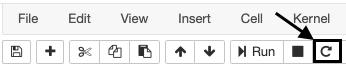

Then, simply import the library and you're ready to go!<br><br>
Note: If you've already installed Koalas in another notebook (or in a terminal session), you won't need to reinstall it.
<footer>Splice Machine</footer>


In [1]:
!pip install koalas

     |████████████████████████████████| 630 kB 12.7 MB/s eta 0:00:01


#### Let's start our Spark Session

In [2]:
# Setup
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

import databricks.koalas as ks
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
from splicemachine.mlflow_support.utilities import get_user

spark = SparkSession.builder.getOrCreate()
splice = PySpliceContext(spark)
schema = get_user()

## Ingesting Data
<blockquote><p class='quotation'><span style='font-size:15px'> There are a variety of ways to ingest data into Splice Machine. here we'll use the built in <code>IMPORT_DATA</code> SQL function to bring data from s3 directly into a Splice Machine table. From there we'll be able to investigate our features. <footer>Splice Machine</footer>
</blockquote>

In [3]:
%%sql
drop table if exists cc_fraud_data; 
create table cc_fraud_data (
    time_offset integer,
    expected_weekly_trans_cnt double,
    expected_weekly_trans_amnt double,
    expected_daily_trans_cnt double,
    expected_daily_trans_amnt double,
    weekly_trans_cnt double,
    weekly_trans_amnt double,
    daily_trans_cnt double,
    daily_trans_amnt double,
    rolling_avg_weekly_trans_cnt double,
    rolling_avg_weekly_trans_amnt double,
    rolling_avg_daily_trans_cnt double,
    rolling_avg_daily_trans_amnt double,
    MACD_trans_amnt double,
    MACD_trans_cnt double,
    RSI_trans_amnt double,
    RSI_trans_cnt double,
    Aroon_trans_amnt double,
    Aroon_trans_cnt double,
    ADX_trans_amnt double,
    ADX_trans_cnt double,
    current_balance double,
    rolling_avg_balance double,
    MACD_balance double,
    Aroon_balance double,
    RSI_balance double,
    ADX_balance double,
    credit_score double,
    credit_limit double,
    amount decimal(10,2),
    class_result int
);

call SYSCS_UTIL.IMPORT_DATA (
     null,
     'cc_fraud_data',
     null,
     's3a://splice-demo/kaggle-fraud-data/creditcard.csv',
     ',',
     null,
     null,
     null,
     null,
     -1,
     's3a://splice-demo/kaggle-fraud-data/bad',
     null, 
     null);
     

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sql started successfully



## We can use `SQL` natively to investigate our data

In [4]:
%%sql
-- Get the class distribution of our label
select class_result, count(*) as NUM_Occurrences
from cc_fraud_data 
group by class_result

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
%%sql 
-- Calculate averages for some important metrics
SELECT class_result, AVG(expected_weekly_trans_cnt) as avg_expected_weekly_trans_cnt, 
AVG(MACD_trans_amnt) as avg_MACD_trans_amnt, 
AVG(RSI_trans_amnt) as avg_RSI_trans_amnt
from cc_fraud_data
group by class_result

## Using the Native Spark Data Source (and Koalas) to get our data in PySpark

In [8]:
df = splice.df(f"SELECT * FROM {schema}.cc_fraud_data").to_koalas().astype({'AMOUNT': 'float64'})
print(type(df))

<class 'databricks.koalas.frame.DataFrame'>


Visualizing this dataframe without executing a collect operation

In [11]:
df

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TIME_OFFSET,EXPECTED_WEEKLY_TRANS_CNT,EXPECTED_WEEKLY_TRANS_AMNT,EXPECTED_DAILY_TRANS_CNT,EXPECTED_DAILY_TRANS_AMNT,WEEKLY_TRANS_CNT,WEEKLY_TRANS_AMNT,DAILY_TRANS_CNT,DAILY_TRANS_AMNT,ROLLING_AVG_WEEKLY_TRANS_CNT,ROLLING_AVG_WEEKLY_TRANS_AMNT,ROLLING_AVG_DAILY_TRANS_CNT,ROLLING_AVG_DAILY_TRANS_AMNT,MACD_TRANS_AMNT,MACD_TRANS_CNT,RSI_TRANS_AMNT,RSI_TRANS_CNT,AROON_TRANS_AMNT,AROON_TRANS_CNT,ADX_TRANS_AMNT,ADX_TRANS_CNT,CURRENT_BALANCE,ROLLING_AVG_BALANCE,MACD_BALANCE,AROON_BALANCE,RSI_BALANCE,ADX_BALANCE,CREDIT_SCORE,CREDIT_LIMIT,AMOUNT,CLASS_RESULT
0,128750,-2.608490,-1.679881,0.811057,0.093623,0.942956,-0.759330,-0.824826,0.822160,0.028462,-0.714276,0.531187,0.685981,-0.176903,0.609683,0.364776,0.422533,-0.579011,1.213830,0.257625,0.903958,0.581450,0.689316,0.038158,0.777709,0.042208,-0.213716,0.264052,-0.198031,126.51,0
1,156285,-1.775442,-2.079578,0.953471,-1.916621,-0.634549,0.258555,-1.038109,0.808690,-0.569585,-0.367215,-0.813363,0.110627,0.586739,-0.209786,-0.379961,0.108315,-1.049988,2.678667,-0.824483,0.247698,0.176571,0.085100,0.385287,-1.075295,-0.846895,1.163656,-0.036655,-0.092043,212.09,0
2,78123,1.242281,0.199481,0.173321,0.642029,-0.483888,-1.390820,0.287118,-0.296766,-0.008904,-0.018249,-0.127030,-0.062092,-0.700882,0.566435,0.853531,-0.054381,-0.116866,-0.530573,-0.200180,-0.135933,-0.041422,-0.148216,-0.016139,0.747942,0.475955,0.453556,-0.066222,0.008288,16.11,0
3,157283,-1.068117,1.665038,0.071882,3.651713,0.966413,-0.314418,0.321383,0.484625,-1.549221,-0.599756,-0.675101,-0.730229,0.487957,-3.140239,-0.357058,2.256846,1.585042,1.279793,-1.614902,-0.232853,-0.213974,-0.617424,0.636688,-0.459300,-1.141013,-0.425170,0.102049,0.195807,34.10,0
4,129624,2.039434,-0.191210,-1.232785,0.208475,0.050459,-0.600238,-0.011161,-0.078737,0.461102,0.264371,0.478456,0.476902,-0.967601,0.655118,-0.472873,0.196391,-0.569625,-0.208929,0.521220,-0.273200,-0.270048,-0.718989,0.298044,-0.493856,-0.324286,0.211821,-0.078369,-0.077036,0.99,0
5,158249,-0.507760,1.215373,-0.660998,1.229256,-0.421220,-0.800873,-0.186379,0.542027,-0.584138,0.040927,-1.031885,0.165738,0.035043,1.034963,1.145920,-1.034242,1.016882,-0.348190,2.712278,-0.128629,0.013662,-0.092656,0.343884,0.017528,-1.739495,0.417558,-0.218392,0.141289,9.99,0
6,51624,-2.217369,1.259382,1.624812,1.121974,-0.563962,1.933695,-2.479092,-4.441567,-0.047194,0.016005,-0.128551,-0.299969,-1.322662,0.676513,1.855031,0.856294,-0.396717,2.092577,1.632619,0.046087,1.115568,0.432396,0.414261,-0.893231,0.317314,0.143383,0.667675,0.086776,23.49,0
7,130538,2.006811,-0.057717,-0.995719,0.305787,-0.036855,-0.837389,0.111646,-0.203972,0.176653,0.214957,1.193778,1.519209,0.607681,0.353737,-0.690347,-0.022427,-0.488797,-0.570276,0.327900,-0.182710,-0.219249,-0.493992,0.337948,0.035603,-0.332580,0.176300,-0.066866,-0.068587,0.89,0
8,159214,0.256621,0.223809,0.975735,-0.220988,-0.270464,0.568080,-0.394989,-0.637367,0.416232,-0.543426,0.802522,1.400141,0.805273,-0.081653,-0.281695,0.138581,-0.678394,0.757668,0.160874,-0.084076,1.080174,0.763228,-0.220929,0.824970,0.789579,-0.064883,0.223809,0.257101,39.95,0
9,78878,-0.438668,1.047467,1.703435,0.046779,-0.225900,-1.094178,0.697298,-0.082498,-0.406396,-0.308439,-0.118538,0.023341,-0.093484,0.175333,0.831681,0.105760,-0.270247,-0.451177,-0.108440,0.080611,-0.207559,-0.540343,0.017062,0.690734,-0.240261,0.051245,0.265558,0.124202,1.29,0


## Let's use Koalas
<blockquote><p class='quotation'><span style='font-size:15px'> Now that we have our Koalas dataframe, we can use standard Pandas API, but distribute it all on Spark. Let's try some standard functions, and inspect what Koalas is doing under the hood <footer>Splice Machine</footer>
</blockquote>

In [9]:
# Sort by amount spent in transaction, looking at Amount, Current balance, and Weekly Transaction count
df.sort_values(by='AMOUNT', ascending=False)[['AMOUNT','CURRENT_BALANCE', 'WEEKLY_TRANS_CNT']]

,AMOUNT,CURRENT_BALANCE,WEEKLY_TRANS_CNT
109870,25691.16,-21.620120,-113.743307
156529,19656.53,11.455313,-20.672064
268255,18910.00,11.502580,-19.229075
248804,12910.93,7.921600,-13.945538
107734,11898.09,7.437478,-12.880794
230589,11789.84,6.829810,-10.866639
3414,10199.44,-0.269048,-40.427726
114355,10000.00,5.198718,3.957175
138216,8790.26,-5.932594,-27.752964
276633,8787.00,5.788207,-7.855074


In [12]:
# See rows with WEEKLY_TRANS_AMNT above 25
df[df['WEEKLY_TRANS_AMNT'] > 18]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TIME_OFFSET,EXPECTED_WEEKLY_TRANS_CNT,EXPECTED_WEEKLY_TRANS_AMNT,EXPECTED_DAILY_TRANS_CNT,EXPECTED_DAILY_TRANS_AMNT,WEEKLY_TRANS_CNT,WEEKLY_TRANS_AMNT,DAILY_TRANS_CNT,DAILY_TRANS_AMNT,ROLLING_AVG_WEEKLY_TRANS_CNT,ROLLING_AVG_WEEKLY_TRANS_AMNT,ROLLING_AVG_DAILY_TRANS_CNT,ROLLING_AVG_DAILY_TRANS_AMNT,MACD_TRANS_AMNT,MACD_TRANS_CNT,RSI_TRANS_AMNT,RSI_TRANS_CNT,AROON_TRANS_AMNT,AROON_TRANS_CNT,ADX_TRANS_AMNT,ADX_TRANS_CNT,CURRENT_BALANCE,ROLLING_AVG_BALANCE,MACD_BALANCE,AROON_BALANCE,RSI_BALANCE,ADX_BALANCE,CREDIT_SCORE,CREDIT_LIMIT,AMOUNT,CLASS_RESULT
3414,172273,-9.030538,-11.112584,-16.233798,3.592021,-40.427726,23.917837,44.054461,-7.277778,-4.210637,-7.776435,0.214173,-4.499851,0.241005,0.537895,2.901938,2.326099,-0.402142,1.257379,2.008145,2.454553,-0.269048,0.988144,7.040028,0.347693,2.520869,2.342495,3.478175,-2.713136,10199.44,0
84049,32605,-23.383129,-18.098804,-20.195367,4.249104,-42.147898,22.529298,36.677268,-4.862800,1.645619,-7.761890,-0.051013,-0.023820,3.027414,-0.504989,2.032532,6.098529,-0.205514,-1.031321,0.220769,-13.694584,-5.893230,-0.139751,-6.086173,1.924973,0.669689,0.449781,11.135740,-9.617915,7429.15,0
84132,132779,-4.389647,-1.993089,-12.627453,0.282311,-29.730600,21.307738,31.527244,-6.354233,-0.293293,-3.399167,1.811068,-1.721828,0.787292,-1.516869,0.654465,2.797421,-1.660478,-1.636735,-0.468863,-10.347328,-3.801492,1.757957,-2.139086,-0.025463,-1.914228,0.275607,4.655054,-1.398364,6454.74,0
86986,67676,-7.103082,-1.706830,-9.726332,1.657590,-31.356750,20.379524,29.205868,-5.498667,-1.369680,-3.713841,2.212401,-1.534510,0.816452,-1.187157,0.949474,4.594817,-1.560379,-0.739444,-2.004658,-8.817441,-2.719498,0.876382,-2.041865,0.603670,0.321988,1.268208,5.868242,-4.071666,6239.54,0
109870,166198,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,-12.005487,6.853897,-9.189418,7.126883,-6.795942,8.877742,17.315112,-7.173805,-1.968044,5.501747,-54.497720,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0
138216,55709,-16.950064,-16.417395,-12.523381,6.555638,-27.752964,18.072031,28.504065,-10.152220,2.124673,-2.856014,0.121804,-1.619834,2.231107,-3.041540,2.630401,5.000096,-1.745472,-1.129167,2.639624,-19.902611,-5.932594,0.050097,-10.855949,1.550407,-0.502172,0.821714,12.152401,-4.009839,8790.26,0
164521,142019,-37.558067,-29.335992,-24.962322,8.413616,-35.182120,21.550496,36.877368,-8.915982,5.046566,0.909474,3.919686,-0.384260,4.316156,-3.113694,5.667667,8.289890,-2.490935,-3.570907,1.663899,-28.009635,-11.263235,-1.150828,-7.800902,1.272716,1.965365,0.767817,3.248189,13.013546,5964.95,0
227447,1264,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,3.702177,-1.843056,2.427123,-1.652836,3.635042,4.087802,-1.654892,-0.888406,0.752276,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43,0
245752,122452,-12.564969,-7.021368,-11.587432,1.988852,-28.815577,21.190194,26.249717,-10.825664,2.961064,-2.436706,1.477686,-0.565587,1.220322,-3.256503,0.308272,4.188611,-1.388924,-1.615656,-0.051057,-17.970675,-1.360000,0.949443,-2.165378,-0.449718,-0.346792,0.837145,5.058448,2.435250,5918.00,0


In [18]:
# See what Koalas is doing under the hood
df[df['WEEKLY_TRANS_AMNT'] > 18].spark.explain()

== Physical Plan ==
*(3) Project [(cast(_we0#96 as bigint) - 1) AS __index_level_0__#94L, TIME_OFFSET#31, EXPECTED_WEEKLY_TRANS_CNT#32, EXPECTED_WEEKLY_TRANS_AMNT#33, EXPECTED_DAILY_TRANS_CNT#34, EXPECTED_DAILY_TRANS_AMNT#35, WEEKLY_TRANS_CNT#36, WEEKLY_TRANS_AMNT#37, DAILY_TRANS_CNT#38, DAILY_TRANS_AMNT#39, ROLLING_AVG_WEEKLY_TRANS_CNT#40, ROLLING_AVG_WEEKLY_TRANS_AMNT#41, ROLLING_AVG_DAILY_TRANS_CNT#42, ROLLING_AVG_DAILY_TRANS_AMNT#43, MACD_TRANS_AMNT#44, MACD_TRANS_CNT#45, RSI_TRANS_AMNT#46, RSI_TRANS_CNT#47, AROON_TRANS_AMNT#48, AROON_TRANS_CNT#49, ADX_TRANS_AMNT#50, ADX_TRANS_CNT#51, CURRENT_BALANCE#52, ROLLING_AVG_BALANCE#53, ... 8 more fields]
+- *(3) Filter CASE WHEN isnull(CASE WHEN isnull((WEEKLY_TRANS_AMNT#37 > 18.0)) THEN false ELSE (WEEKLY_TRANS_AMNT#37 > 18.0) END) THEN false ELSE CASE WHEN isnull((WEEKLY_TRANS_AMNT#37 > 18.0)) THEN false ELSE (WEEKLY_TRANS_AMNT#37 > 18.0) END END
   +- Window [row_number() windowspecdefinition(_w0#95L ASC NULLS FIRST, specifiedwindowfram

## Great! Let's do some investigation
<blockquote><p class='quotation'><span style='font-size:15px'>Now that we see the power of Koalas, let's use it! We'll look at some feature correlations and distributions without having to sample our data.<footer>Splice Machine</footer>
</blockquote>

## Investigating if there exist any correlation among our features

Looks like our feature space is linearly independent and we don't have to eliminate any highly correlated features

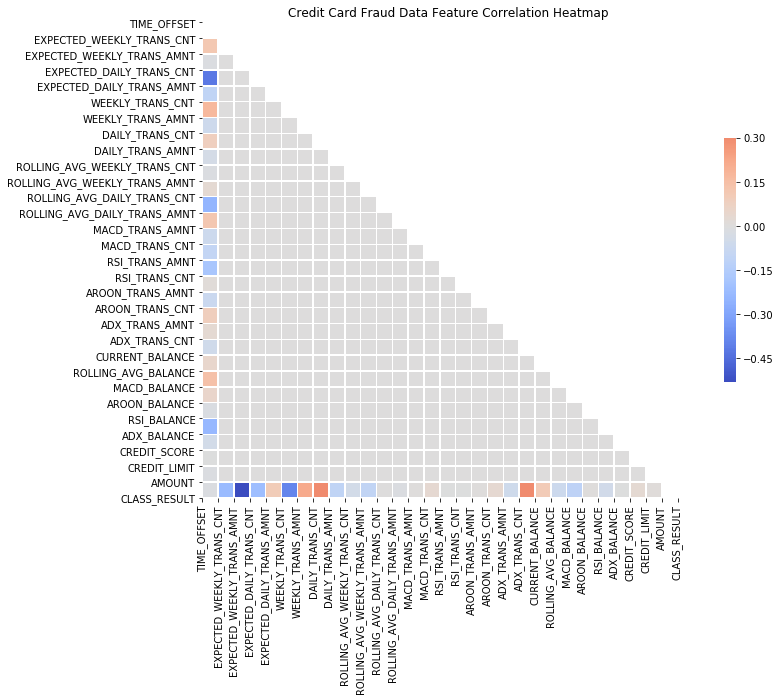

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

corr = df.corr() # This is a koalas dataframe 
corr_pdf = corr.to_pandas() # Doing this so we can easily use the seaborn heatmap functionality

ticks = [i for i in range(len(corr_pdf.columns))]
mask = np.triu(np.ones_like(corr_pdf, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = "coolwarm"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_pdf, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(ticks, corr_pdf.columns)
plt.yticks(ticks, corr_pdf.columns)
plt.title('Credit Card Fraud Data Feature Correlation Heatmap')
plt.show()

## Investigating the distribution of our features

In [16]:
features = list(df.columns)
features.remove("CLASS_RESULT")

In [46]:
# Understanding our features in terms of their spread
df[features].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TIME_OFFSET,EXPECTED_WEEKLY_TRANS_CNT,EXPECTED_WEEKLY_TRANS_AMNT,EXPECTED_DAILY_TRANS_CNT,EXPECTED_DAILY_TRANS_AMNT,WEEKLY_TRANS_CNT,WEEKLY_TRANS_AMNT,DAILY_TRANS_CNT,DAILY_TRANS_AMNT,ROLLING_AVG_WEEKLY_TRANS_CNT,ROLLING_AVG_WEEKLY_TRANS_AMNT,ROLLING_AVG_DAILY_TRANS_CNT,ROLLING_AVG_DAILY_TRANS_AMNT,MACD_TRANS_AMNT,MACD_TRANS_CNT,RSI_TRANS_AMNT,RSI_TRANS_CNT,AROON_TRANS_AMNT,AROON_TRANS_CNT,ADX_TRANS_AMNT,ADX_TRANS_CNT,CURRENT_BALANCE,ROLLING_AVG_BALANCE,MACD_BALANCE,AROON_BALANCE,RSI_BALANCE,ADX_BALANCE,CREDIT_SCORE,CREDIT_LIMIT,AMOUNT
count,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,2.848060e+05,284806.000000,284806.000000,2.848060e+05,284806.000000,284806.000000,2.848060e+05,2.848060e+05,2.848060e+05,284806.000000,2.848060e+05,284806.000000,284806.000000,2.848060e+05,2.848060e+05,2.848060e+05,284806.000000
mean,94813.841366,0.000005,0.000006,-0.000009,-0.000001,-0.000002,-0.000002,0.000006,-0.000003,-0.000011,0.000004,-0.000001,0.000007,-8.120754e-07,-0.000002,0.000011,-7.665150e-08,-0.000002,-0.000004,-2.809276e-07,-7.339478e-07,-7.641722e-07,-0.000003,-9.875288e-07,-0.000003,0.000003,-8.965749e-07,-4.983890e-07,-8.011320e-07,88.349756
std,47488.228330,1.958697,1.651309,1.516250,1.415871,1.380249,1.332273,1.237091,1.194354,1.098620,1.088849,1.020715,0.999196,9.952759e-01,0.958597,0.915298,8.762544e-01,0.849338,0.838175,8.140419e-01,7.709263e-01,7.345252e-01,0.725701,6.244612e-01,0.605647,0.521277,4.822276e-01,4.036331e-01,3.300836e-01,250.120538
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881e+00,-19.214325,-4.498945,-1.412985e+01,-25.162799,-9.498746,-7.213527e+00,-5.449772e+01,-3.483038e+01,-10.933144,-4.480774e+01,-2.836627,-10.295397,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54217.000000,-0.920375,-0.598111,-0.889695,-0.848687,-0.691715,-0.768292,-0.554084,-0.208539,-0.642894,-0.535486,-0.762667,-0.405283,-6.483662e-01,-0.425398,-0.582730,-4.680183e-01,-0.483802,-0.498653,-4.562534e-01,-2.117152e-01,-2.283323e-01,-0.542199,-1.618353e-01,-0.354603,-0.317116,-3.269788e-01,-7.081704e-02,-5.295048e-02,5.600000
50%,84718.000000,0.017972,0.065659,0.179857,-0.020031,-0.054196,-0.274104,0.040140,0.022472,-0.051429,-0.092794,-0.032481,0.139907,-1.365868e-02,0.050556,0.048192,6.635314e-02,-0.065638,-0.003624,3.592694e-03,-6.245793e-02,-2.943410e-02,0.006829,-1.116242e-02,0.040968,0.016486,-5.208850e-02,1.329823e-03,1.124984e-02,22.000000
75%,139311.000000,1.315529,0.803687,1.027121,0.743445,0.611822,0.398550,0.570337,0.327396,0.597077,0.453821,0.739610,0.618079,6.624165e-01,0.493214,0.648682,5.231244e-01,0.399673,0.500644,4.589263e-01,1.329425e-01,1.863291e-01,0.528367,1.475828e-01,0.439510,0.350724,2.408431e-01,9.102976e-02,7.825326e-02,77.150000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883e+00,10.526766,8.877742,1.731511e+01,9.253526,5.041069,5.591971e+00,3.942090e+01,2.720284e+01,10.503090,2.252841e+01,4.584549,7.519589,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


Visualizing our features distributions

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


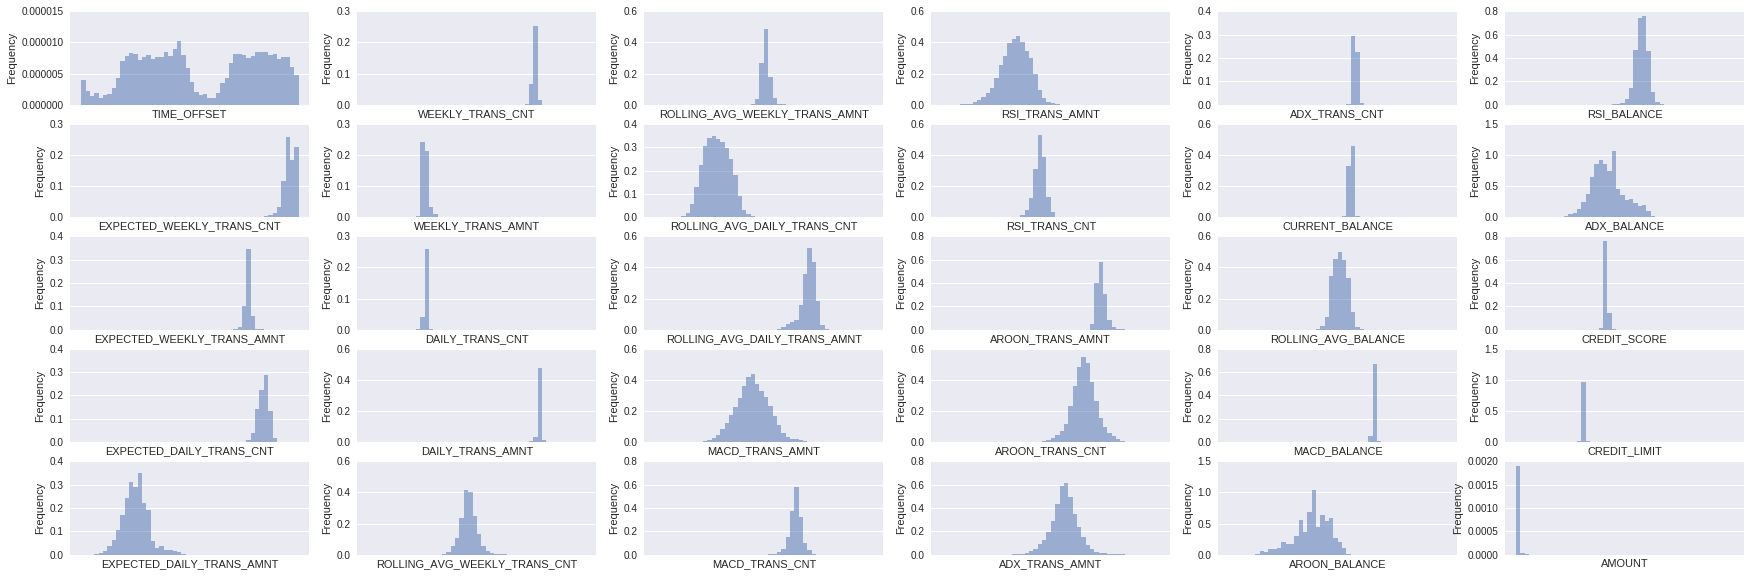

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(30,10))
for i,f in enumerate(features):
    row = i%5
    col = i//5
    axes[row,col] = df[f].plot.hist(bins=50, alpha=0.5,normed = True, ax = axes[row,col])
    axes[row,col].set_xlabel(f)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([round(t,7) for t in axes[row,col].get_yticks()])

## Investigating our features correlation to our target

Text(0.5, 1.0, 'Feature Correlation to Target Variable')

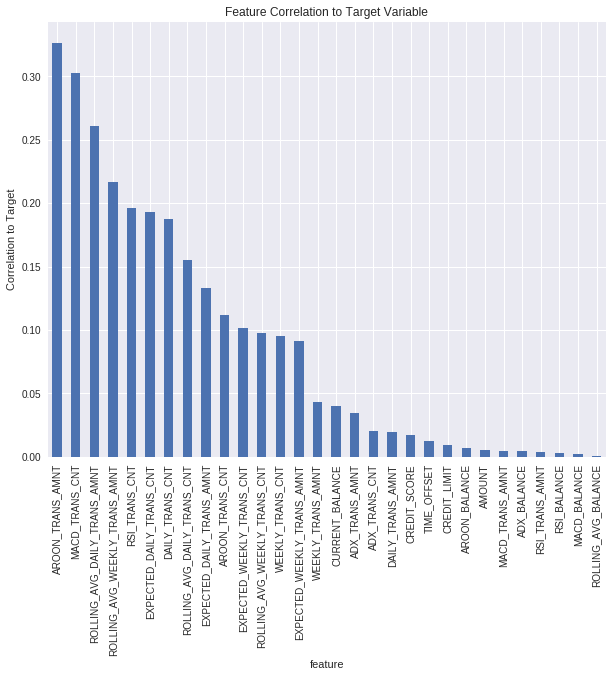

In [53]:
fig, ax = plt.subplots(figsize=(10,8))

most_correlated = corr.abs()['CLASS_RESULT'].sort_values(ascending=False).reset_index()
most_correlated = most_correlated.iloc[1:].rename({"index":"feature","CLASS_RESULT":"correlation_to_target"}, axis = 1)
ax = most_correlated.plot.bar(x = "feature",y = "correlation_to_target", ax = ax, legend = None)
ax.set_ylabel("Correlation to Target") 
ax.set_title("Feature Correlation to Target Variable")


# Fantastic!
<blockquote> 
We've just demonstrated our platform's ability to execute simple feature investigation routines <br>
    Next Up: <a href='./7.4 Feature Engineering.ipynb'>Using MLManager to Engineer Features</a>
<footer>Splice Machine</footer>
</blockquote>